# Upscaling Fine Scale Porous Media Grids for Porous Flow Simulation

<table>
<tr>

    
<td><figure>
    <img align="left" src="img/StreamlineF.png" width="350"/>
    <figcaption>Fine scale streamlines and permeability in X direction</figcaption>
    </figure>
    </td>
<td><figure>    
    <img align="left" src="img/StreamlineHarm.png" width="350" />
    <figcaption>Coarse scale streamlines and permeability in X direction</figcaption>
    </figure>
    </td>
</tr></table> 
<br>
<table>

<details>
<summary><p><font size="4" color="navy"> Click here to Show/Hide Introduction and Outline</font></p></summary>    
    <td><tr>
    <p style="text-align:center;"> <font size="4" color="black"><b>This notebook introduces:</b>
        <ul><li>Corner Point Grids (CPG)</li>
            <li>Permeability tensors and Single Phase Flow in Porous Media</li>
            <li>Upscaling of Single Phase Porous Flow Parameters: Porosity and Permeability</li>
        </ul> <b>The workflow allows you to:</b></font></p>
       <ol style="line-height:2;"><font size="4" color="navy">
            <li><p style="text-align:left;"><a href='#1.-Create-a-Geomodel-discretized-by-a-GRDECL-Pillar-Grid' style="text-decoration:none"> Create a Geomodel discretized by a GRDECL Pillar Grid</a></p></li>
            <li><p style="text-align:left;"><a href='#2.-Generate-Porosity-and-Permeability-Fields-and-Compute-Single-Phase-Flow' 
                            style="text-decoration:none"> Generate Porosity and Permeability Fields and Compute Single Phase Flow</a></p></li>
            <li><p style="text-align:left;"><a href='#3.-Construct-a-Coarse-Grid' 
                            style="text-decoration:none"> Construct a Coarse Grid</a></p></li>
            <li><p style="text-align:left;"><a href='#4.-Upscale-Permeability' 
                            style="text-decoration:none"> Upscale Permeability</a></p>
           <ul> <font size="3">
           <li><p style="text-align:left;"><a href='#&#149;-Power-Averaging-Methods' 
                            style="text-decoration:none"> Power Averaging Methods</a></p></li>
           <li><p style="text-align:left;"><a href='#&#149;-Flow-Based-Methods'
                            style="text-decoration:none">Flow Based Methods</a></p></li>
               </font></ul></li>
       </font></ol>
        </tr></td>
</table>
</details>

## 1. Create a Geomodel discretized by a GRDECL Pillar Grid

<p><font size="2" color="grey">
  Jupyter notebook Hints: &nbsp &nbsp &nbsp &nbsp To run a selected notebook cell press [SHIFT + ENTER]. &nbsp &nbsp &nbsp &nbsp To toggle its output press [0] </font>
</p>   

<details>
<summary><p><font size="4" color="navy"> Click here to Show/Hide Information about Corner Point Grids (CPG)</font></p></summary>
<table><tr> 
        <td><img align="left"  src="img/corner_point_grid.png" width="350" /> <figcaption>Figure 1</figcaption></td>  
        <td><p style="text-align:left;"><font size="3" color="navy">
            <b>Corner Point Grids (CPG):</b><br>
                CPG can be seen as Modified Cartesian Grids with modifications allowing to obtain more flexible and Less Structured Grids. 
        		They are made of hexaedra set on vertical Pillars (<font color="red">red lines</font> in Figure 1) where:
        		<ul>
           			<li><p style="text-align:left;">Each Pillar corresponds to a node of an inital 2D Planar Grid ({ [I, J], I $\in$ {0,2} , J $\in$ {0,1} } in Figure 1) </p></li>
                    <li><p style="text-align:left;">Each Hexaedron  [I,J,K] is set on its 4 surrounding pillars { [I+i, J+j], i,j $\in$ {0,1} }</p></li>
               		<li><p style="text-align:left;">The 8 corners of an hexaedron can slide independently on its 4  pillars</p></li>                    
               	</ul>
               <p style="text-align:left;"><b> Vertical sliding allows to introduce faulting and non orthogonal shapes in CPG  </b></p></font>
        </p></td>
</tr></table>
<p><font size="3" color="navy"><b>This section provides instructions to Create/Visualize a CPG. <br> Four examples are detailed in the figure below (Figure 2). Similarly you can generate your own CPG by setting this parameters:</b></font></p>
<br> 
<img align="center" src="img/GRDECL_simplDisturbed3.png" width="1000"/><figcaption>Figure 2</figcaption>
<br>
 
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>
</details>

In [1]:
from GRDECL2VTK import *
from utils import *

# 1.1 Set physical dimensions in physDims (m)
physDims=[2000.,1000.,500.]

# 1.2 Set model grid dimensions in gridDims
Nx=10;  Ny=Nx;  Nz=Nx
gridDims=[Nx,Ny,Nz]

# 1.3 Set corner point grid options: Disturbed pillars, Flat Grid, Fault 
opt=buildCPGGrid_opt(\
disturbed=False,\
flat=False,\
fault_drop=physDims[2]*0.5,\
fault_nx=Nx//2)

# 1.4 Create empty GeologyModel - Build CPG
Model=GeologyModel()
Model.buildCPGGrid(physDims,gridDims,opt)

# 1.5 Visualize Geometry and check initial parameters
Model.plot_scalar("PERMX",add_log_scale=True).show(show_edges=True)

     Creating Grid:
       Type: CornerPoint Grid
       Grid Dimensions (NX,NY,NZ): (10 x 10 x 10)
       Number Of Grid Cells: 1000
       Created: Fields: ***PERMX***PERMY***PERMZ***PORO***
[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 8000
     NumOfCells 1000
     .....Done!
[Output] Writing "Results\PILLAR_Grid.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

## 2. Generate Porosity and Permeability Fields and Compute Single Phase Flow

<details>
    <summary><p><font size="4" color="navy"> Click here to Show/Hide Information about Permeability and Pressure computation</font></p></summary>
<table><tr> 
        <td><img align="left"  src="img/darcy" width="1000" /> <figcaption>Figure 1</figcaption></td>  
        <td><p style="text-align:left;"><font size="3" color="navy">
            <b>Absolute Permeability $K$:</b><br>
                Permeability (H.Darcy, 1856) is the ability of a porous medium to conduct fluids in its interconnected pores. The absolute permeability controls fluid flow rates depending on considered directions. It is a second order tensor $\left(\overline{\overline K}\right)$with lognormal distributed components. In many practical situation it is assumed to be transversaly isotropic (horizontally isotropic):
            $\begin{pmatrix}K_H & 0 & 0\\0 & K_H & 0 \\ 0 & 0 & K_V\end{pmatrix} \quad (K_H>K_V)$
            </font></p></td>
</tr></table> 
<table><tr> 
        <td><img align="left"  src="img/TPFA_drops.png" width="750" /> <figcaption>Figure 2</figcaption></td>  
        <td><p style="text-align:left;"><font size="3" color="navy">
            <b>Single Phase Flow Equation:</b><br>
            The pressure equation, for a steady single phase Darcy flow with incompressible fluid and rock  and no gravity, follows:

$\begin{equation}
\left\lbrace 
\begin{array}{ll}  
\vec{v} &=-\frac{K}{\mu} \nabla P \\ 
\nabla \ldotp \left(\rho \vec{v} \right) &=q 
\end{array}
\right. 
\label{eq:1}
\end{equation}$<br>.<br>
               For our single phase upscaling tests we use its simplified version:<br>$\begin{equation}
\left\lbrace 
\begin{array}{cll}  
\nabla \ldotp \left(-K \nabla P \right) &=0 \qquad &in \: \Omega\\ 
P&=P_0  \qquad &in \:  \Gamma_{Dir}\\
K \nabla P\cdot n&=0 &in \:  \Gamma_{Neum}\\
\end{array}
\right.
\end{equation}$<br>
            This equation is solved numerically with a  Two Point Flux Approximation (TPFA) Solver (Pressure Solutions for faulted and non faulted configurations are shown in Figure2). 
            </font></p></td>
</tr></table>          
    <p><font size="4" color="navy">This section provides instructions to:
    <ol>
        <li>Generate and Visualize porosities and LogNormal permeabilities distributions (transversely isotropic) for:
        <ul><li>Horizontally Layered distributions</li>
            <li>Basculed Layered distributions</li>
            <li>A mix of Horizontal and Basculed Layered distributions</li></ul></li>
        <li>Compute and Visualize pressure  and flow streamlines (TPFA solver, K-orthogonal CPG)</li> 
    </ol></font>
<table>
    <td><img align="center" src="img/layered_basculed_K50.png" width="500"/></td>
    <td><img align="center" src="img/layered_basculed_PV50.png" width="600"/> </td>
</table>
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>
</details>    

[logNormLayers] Filling K and Phi Z layers with log normal distributions
[UpdateListCellData] varname:PORO
[UpdateListCellData] varname:PERMX
[UpdateListCellData] varname:PERMY
[UpdateListCellData] varname:PERMZ


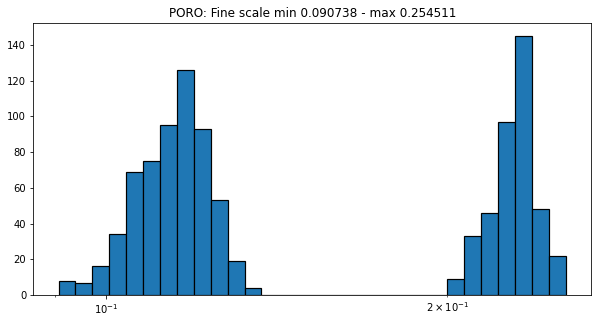

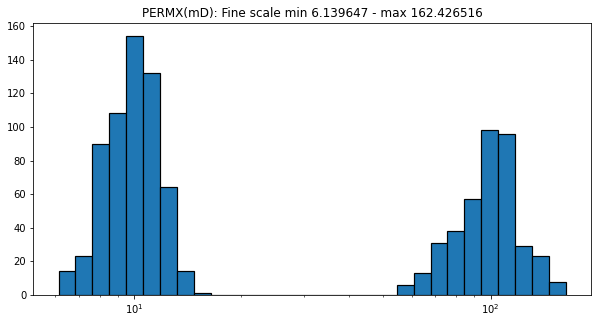

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 8000
     NumOfCells 1000
     .....Done!
[Output] Writing "Results\PILLAR_Grid.vtu" Paraview file....Done!


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 8000
     NumOfCells 1000
     .....Done!
[Output] Writing "Results\PILLAR_Grid.vtu" Paraview file....Done!


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [10]:
# 2.1 Set list of vertical permeability values
K_LayerPerm=[100,10]*2 # produces layers: [100,10,100,10] (mD)

# 2.2 Fill grid with permeability from the previous list 
# Choose one of the 3 possibilities
K,phi=logNormLayers(gridDims,K_LayerPerm,poro_const=0.05)
# K,phi=logNormLayers_basc(gridDims,K_LayerPerm,poro_const=0.05)
# K,phi=logNormLayers_mixed_basc_horiz(gridDims,K_LayerPerm,poro_const=0.05,Zcut_ratio=0.25)

# 2.3 Update porosity/permeability diagonal components with generated grid values
# We use transversaly isotropic values with K_V=K_H/100
Update_fields=["PORO","PERMX","PERMY","PERMZ"]
Update_values=[ phi  , K     , K     , 0.01*K ]
Model.UpdateListCellData(var_list=Update_fields,array_list=Update_values)

# 2.4 Visualize Fine scale histograms
for scalar in ["PORO","PERMX"]:
    Model.GRDECL_Data.Plot_hist(scalar,text="Fine scale")

# 2.5 Compute TPFA Pressure values
Model.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt)

# 2.6 Visualize P and V
Model.plot_scalar("PERMX",ITK=True).show()
pl=Model.plot_streamlines(notebook=True, scalar="PERMXLOG10").show()

##  3. Construct a Coarse Grid
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>

<details>
    <summary><p><font size="4" color="navy"> Click here to Show/Hide Information about Coarse Grid Generation</font></p></summary>
<table><tr> 
        <td><img align="left"  src="img/Partitioning.png" width="1500" /> <figcaption>Figure 1</figcaption></td>  
        <td><p style="text-align:left;"><font size="3" color="navy">
            <b>Grid Coarsening:</b><br>
                We divide the initial grid in each direction. Each grid dimensions $N_X,\: N_Y,\: N_Z$ is divided by the scaling factors $r_x,\: r_y,\: r_z$. Depending on remainders it produces coarse cells of size  $r_x\times r_y \times r_z$ or smaller cells. We can observe in Figure 1 that the coarse cells not contiguous to the fault have size $5\times 11 \times 11$ and that near the fault the other coarse cells have size $6\times 11 \times 11$  avoiding size $1\times 11 \times 11$ coarse cells. 
            </font></p></td>
</tr></table>          
    <p><font size="4" color="navy">This section provides instructions to:
    <ol>
        <li>Set coarsening factors </li>
        <li>Create the Coarse Grid</li>
        <li>Print the list of all the upscaling methods implemented  in this notebook"
    </ol></font>
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>
</details>    

# 3.1 Set coarsening factor (grid dimensions of coarse cells)
Model.GRDECL_Data.coarse2fine_ratio=[5]*3

# 3.2 Create coarse grid and upscale porosity
Model2=Model.create_coarse_model()

# List of implemented upscaling methods
print(Model.Upscaler.list_upscale_methods())

[Partioning] Partitoning from Fine grid of size: [10,10,10] to Coarse grid of size: [2,2,2]


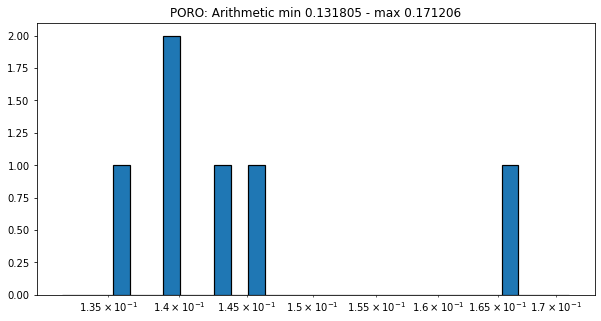

['Upscale_Arithmetic_mean', 'Upscale_Geometric_mean', 'Upscale_Harmonic_mean', 'Upscale_Harmx_mean', 'Upscale_Harmy_mean', 'Upscale_Harmz_mean', 'Upscale_Perm', 'Upscale_TPFA_glob', 'Upscale_TPFA_loc', 'Upscale_TPFA_loc_vol_average']


In [3]:
# 3.1 Set coarsening factor (grid dimensions of coarse cells)
Model.GRDECL_Data.coarse2fine_ratio=[5]*3

# 3.2 Create coarse grid and upscale porosity
Model2=Model.create_coarse_model()

# List of implemented upscaling methods
print(Model.Upscaler.list_upscale_methods())

##  4. Upscale Permeability

### &#149; Power Averaging Methods
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>


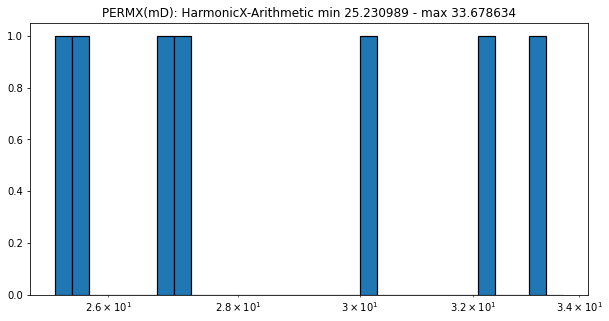

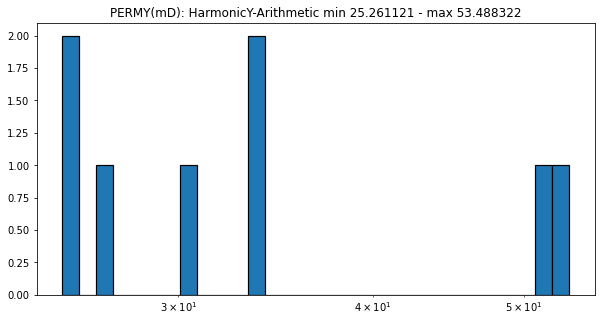

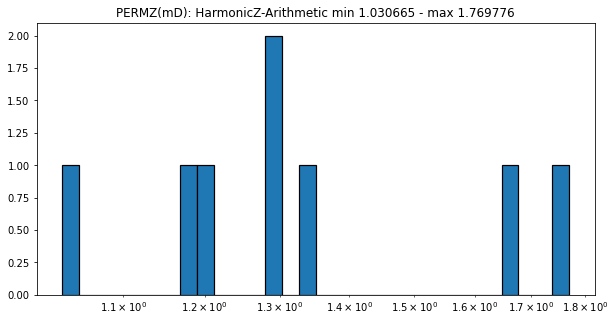

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 64
     NumOfCells 8
     .....Done!
[Output] Writing "Results\PILLAR_Grid_Coarse.vtu" Paraview file....Done!
[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 64
     NumOfCells 8
     .....Done!
[Output] Writing "Results\PILLAR_Grid_Coarse.vtu" Paraview file....Done!


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [4]:
# 3.3 Upscaling
Model.Upscale_Perm(['Harmx_mean','Harmy_mean','Harmz_mean'])

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt)
# # Model.two_plots_scalar("Pressure").show(False)
Model2.plot_scalar("PERMX",add_log_scale=True)

Model2.plot_streamlines(notebook=True, scalar="V").show()

In [5]:
# # 3.3 Upscaling
# Model.Upscale_Perm('Harmz_mean')

# # 3.3 Compute Pressure for coarse model
# Model2.compute_TPFA_Pressure(Press_inj=1,direction="i",Fault_opt=opt )
# # # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()



### &#149; Flow Based Methods
<p style="text-align:right;"><a href='#Upscaling-Fine-Scale-Porous-Media-Grids-for-Porous-Flow-Simulation'>Go to the Table of contents</a></p>

[UPSCALING TPFA loc], nlayer: 2


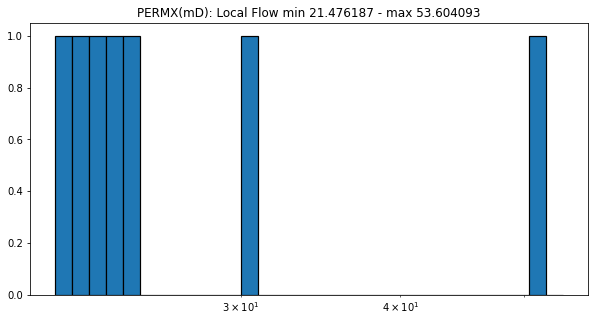

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 8000
     NumOfCells 1000
     .....Done!
[Output] Writing "Results\PILLAR_Grid.vtu" Paraview file....Done!


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [8]:
# 3.3 Upscaling
Model.Upscaler.nlayer=2
Model.Upscaler.Lin_BC=True
Model.Upscale_Perm('TPFA_loc')

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt )
# # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()
Model.plot_streamlines(notebook=True, scalar="V").show()

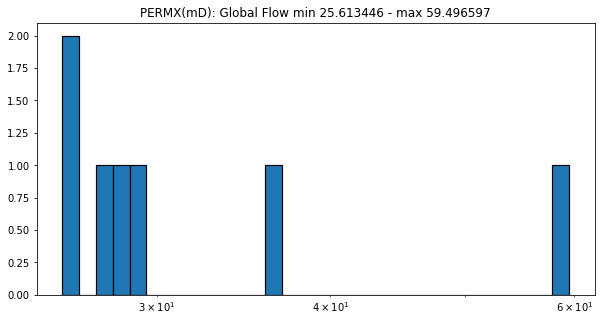

[Geometry] Converting GRDECL to Paraview Hexahedron mesh data....
     NumOfPoints 8000
     NumOfCells 1000
     .....Done!
[Output] Writing "Results\PILLAR_Grid.vtu" Paraview file....Done!


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [9]:
# 3.3 Upscaling
Model.Upscaler.nlayer=0
Model.Upscaler.Lin_BC=False
Model.Upscale_Perm('TPFA_glob')

# 3.3 Compute Pressure for coarse model
Model2.compute_TPFA_Pressure(Press_inj=1,direction="ijk",Fault_opt=opt )
# # Model.two_plots_scalar("Pressure").show(False)
# Model2.plot_scalar("Pressure").show()
Model.plot_streamlines(notebook=True, scalar="V").show()